# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [234]:
from sklearn.base import ClusterMixin
import random
from collections import Counter

class KMeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        
        if random_state != None:
            np.random.seed(random_state)
        else:
            np.random.seed(10)
        
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        
        
            
    def initialize_centroids(self, X):
        """
        Процедура инициализации начальных значений центроидов
        """
        
        # Инициализация генератора случайных чисел
        
        #epsilon
        self.eps = 0.001
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(X.shape[0])
        
        # Массив с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        # Делаем случайные центры (k-means)
        if self.init == 'random':
            idxs = random.sample(xrange(X.shape[0]), self.k)
            self.centroids = np.array([X[idxs[i],] for i in xrange(self.k)])
                
        # k-means++
        elif self.init == 'k-means':            
            self.centroids[0] = X[np.random.randint(0, self.k),]
            
            for centroids_num in xrange(1, self.k):
                prob =[]
                cum_prob = []
                for point in xrange(X.shape[0]):
                    dist = [((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(centroids_num)]
                    
                    # Вероятности
                    prob += [min(dist)]
                    
                    # Накопленные вероятности
                    cum_prob += [np.array(prob).sum()]
                    
                all_prob = np.array(prob).sum()
                all_prob *= np.random.random_sample()
                
                # Выбираем наиболее вероятный
                for prob in cum_prob:
                    if prob > all_prob:
                        self.centroids[centroids_num] = X[cum_prob.index(prob),]
                        break
            

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        self.initialize_centroids(X)
        
        # k-means
        iter_num = 0
        for iter_num in xrange(self.max_iter):
            fixed_number = 0
            
            # Делим все на кластеры
            for point in xrange(X.shape[0]):
                dist = [np.sqrt(((self.centroids[i] - X[point, ]) ** 2).sum()) for i in xrange(self.k)]
                self.labels[point] = np.argmin(dist)
        
            # Пересчитываем центры
            cnt = Counter(self.labels)
                        
            for clast in xrange(self.k):
                sum_coord = np.zeros(X.shape[1])
                
                for point in xrange(X.shape[0]):
                    if (self.labels[point] == clast):
                        sum_coord += X[point, ]

               
                new_centroid = sum_coord / np.array([cnt[clast] for i in xrange(X.shape[1])])
                
                if (np.abs(new_centroid - self.centroids[clast]) < self.eps).all():
                    fixed_number += 1 
                
                self.centroids[clast] = new_centroid
        
            iter_num += 1
            if fixed_number == self.k:       
                break
            
        # print "Iterations number: {}".format(iter_num)        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.labels, self.centroids

class MiniBatchKMeans(KMeans):
    def __init__(self, k=2, batch_size=50, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :batch_size - количество
        """
        super(MiniBatchKMeans, self).__init__(k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    
    
    def fit(self, X, y=None):
        """
        Процедура обучения mini-batch k-means 
        """       
        
        dist = np.empty((self.k, X.shape[0]))
        self.initialize_centroids(X) 
        
        cluster_sizes = np.zeros(self.k)
        old_centroids = np.copy(self.centroids)
        approx = np.empty(self.k)
                                 
        for iter_num in xrange(self.max_iter):
            # Новая случайная выборка
            idxs = random.sample(xrange(X.shape[0]), self.batch_size)
            batch = np.array([X[idxs[i]] for i in xrange(self.batch_size)])
            
            # Собираем расстояния до центроидов
            for clast in xrange(self.k):
                for point in xrange(self.batch_size):
                    dist[clast, point] = ((self.centroids[clast] - batch[point, ]) ** 2).sum()
                    
            # Шаг алгоритма
            for point in xrange(self.batch_size):
                curr_clast = np.argmin(dist[:, point])
                cluster_sizes[curr_clast] += 1
                theta = 1 / cluster_sizes[curr_clast]
                self.centroids[curr_clast,] = (1 - theta) * self.centroids[curr_clast] + theta * batch[point]
                
            # Условие остановки
            for clast in xrange(self.k):
                approx[clast] = np.sqrt(((self.centroids[clast] - old_centroids[clast]) ** 2).sum())
            if max(approx) < self.eps:
                break
                
            old_centroids = np.copy(self.centroids)
            
            # Считаем метки
            for clast in xrange(self.k):
                for point in xrange(X.shape[0]):
                    dist[clast, point] = np.sqrt(((self.centroids[clast] - X[point,]) ** 2).sum())
            
            for point in xrange(X.shape[0]):
                self.labels[point] = np.argmin(dist[:, point])
            
      
            iter_num += 1
        
        # print "Iterations number: {}".format(iter_num) 
        


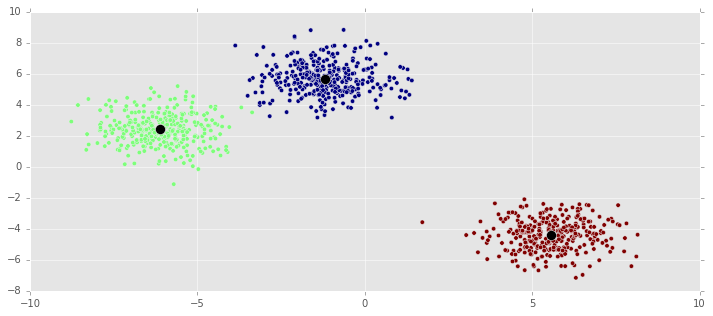

In [235]:
## Работоспособность KMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='random', random_state=123)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены.
# Вероятно, это происходит, когда две случайно выбранные начальные координаты центров попадают в один кластер.

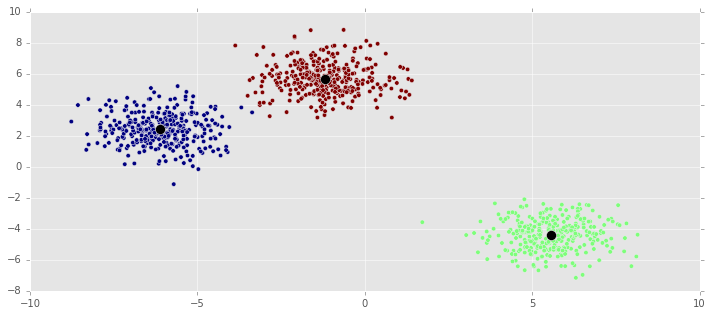

In [236]:
## Работоспособность KMeans++

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='k-means')
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены (вроде бы реже, чем при обычном k-means)
# Происходит это потому что выбор нового центроида тоже происходит случайно.

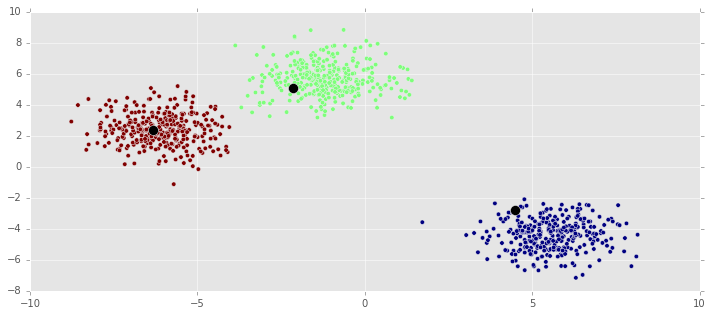

In [237]:
## Работоспособность KMeans с MiniBatchKMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = MiniBatchKMeans(k=3,  init='random', random_state=123, batch_size=50, max_iter=10)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

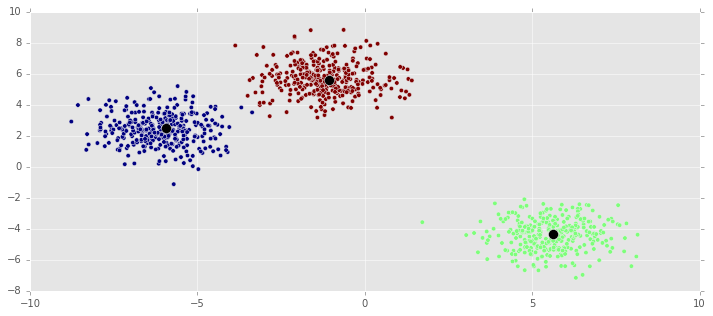

In [238]:
## Работоспособность KMeans++ с MiniBatchKMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, batch_size=50, max_iter=5)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

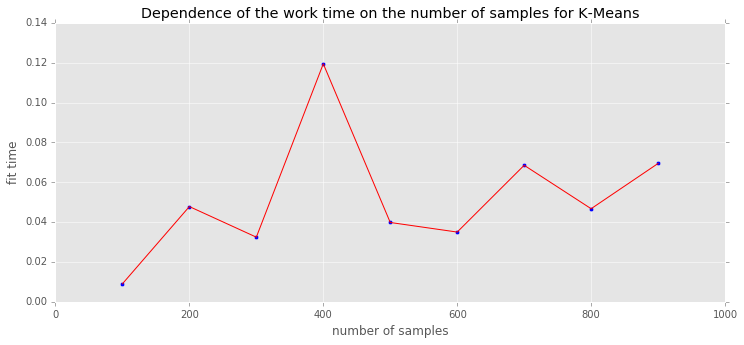

In [239]:
## Время выполнения алгоритма KMeans

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = KMeans(k=3,  init='random', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for K-Means')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# Очень странно и иногда довольно рандомно    

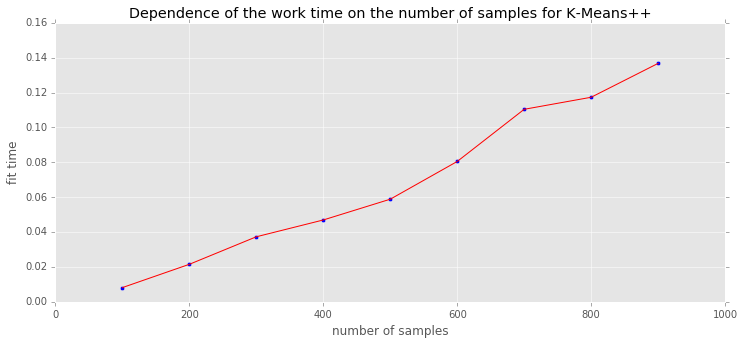

In [240]:
## Время выполнения алгоритма KMeans++

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = KMeans(k=3,  init='k-means', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for K-Means++')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# Уже намного стабильнее, но в большинстве случаев дольше

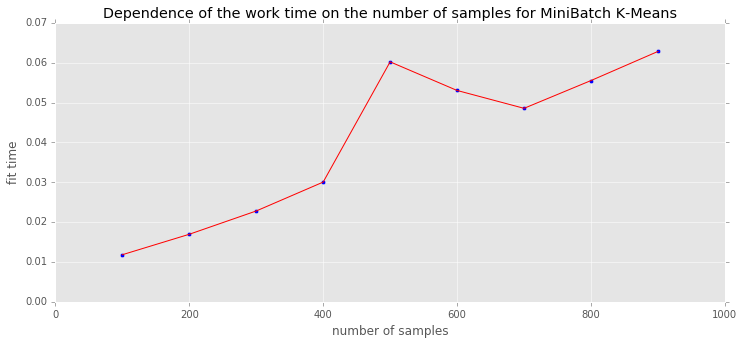

In [253]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = MiniBatchKMeans(k=3,  init='random', random_state=123, max_iter=5)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for MiniBatch K-Means')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# Немного быстрее

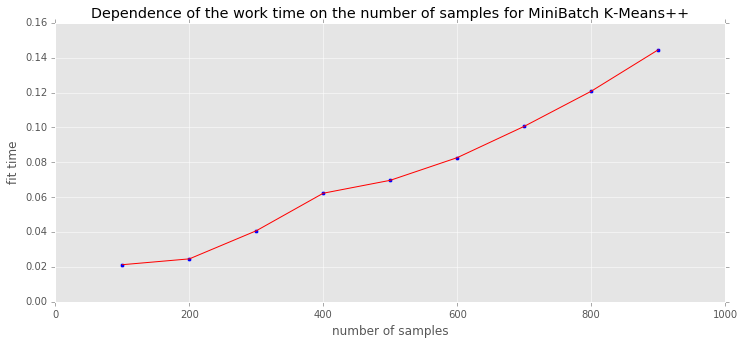

In [252]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, max_iter=5)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for MiniBatch K-Means++')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# На небольших объемах быстрее обычного K-Means++, а дальше медленнее

# Применение K-means на реальных данных

In [243]:
df_sns = pd.read_csv('snsdata.csv', sep=',').dropna()
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2006,F,18.930,72,0,0,0,0,0,0,...,0,2,0,0,2,0,0,0,0,0


In [244]:
X = df_sns.iloc[:, 4:].values
X_train = (X - X.mean(axis=0)) / X.std(axis=0)

In [247]:
## KMeans
model = KMeans(k=9,  init='random', random_state=123, max_iter=1)
model.fit(X_train)
y, centers = model.predict(X_train)

df_sns.loc[:, 'label'] = y
for label, group in df_sns.groupby('label'):
    print('='*20)
    print('Cluster label = {}'.format(label))
    print('='*10)
    
    print(group.head())


Cluster label = 0.0
    gradyear gender     age  friends  basketball  football  soccer  softball  \
53      2006      F  19.526        8           0         2       0         0   
54      2006      M  18.782       26           0         0       1         0   
58      2006      M  19.053       11           0         3       0         0   
65      2006      F  19.107        0           0         0       0         0   
86      2006      M  18.355        2           0         2       0         0   

    volleyball  swimming  ...    mall  shopping  clothes  hollister  \
53           0         0  ...       0         0        0          0   
54           0         1  ...       0         0        2          1   
58           0         0  ...       2         0        0          0   
65           0         1  ...       0         0        0          0   
86           0         0  ...       0         0        0          0   

    abercrombie  die  death  drunk  drugs  label  
53            0    0 

In [249]:
## KMeans++
## KMeans
model = KMeans(k=9,  init='k-means', random_state=123, max_iter=1)
model.fit(X_train)
y, centers = model.predict(X_train)

df_sns.loc[:, 'label'] = y
for label, group in df_sns.groupby('label'):
    print('='*20)
    print('Cluster label = {}'.format(label))
    print('='*10)
    
    print(group.head())


Cluster label = 0.0
    gradyear gender     age  friends  basketball  football  soccer  softball  \
2       2006      M  18.335       69           0         1       0         0   
30      2006      F  18.793        1           0         0       0         0   
36      2006      F  19.053      212           1         1       0         0   
51      2006      M  18.576       26           0         0       0         0   
56      2006      F  18.374       37           1         0       0         0   

    volleyball  swimming  ...    mall  shopping  clothes  hollister  \
2            0         0  ...       0         0        0          0   
30           0         0  ...       0         0        0          0   
36           0         0  ...       0         1        0          0   
51           0         0  ...       0         0        0          0   
56           0         0  ...       0         0        0          0   

    abercrombie  die  death  drunk  drugs  label  
2             0    0 

In [250]:
## KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k=9,  init='random', random_state=123, max_iter=1, batch_size=100)
model.fit(X_train)
y, centers = model.predict(X_train)

df_sns.loc[:, 'label'] = y
for label, group in df_sns.groupby('label'):
    print('='*20)
    print('Cluster label = {}'.format(label))
    print('='*10)
    
    print(group.head())


Cluster label = 0.0
     gradyear gender     age  friends  basketball  football  soccer  softball  \
52       2006      F  19.159        0           0         0       0         0   
116      2006      F  19.255        0           1         2       1         1   
121      2006      F  19.006       41           0         0       0         0   
178      2006      F  19.143        9           1         2       0         0   
186      2006      F  18.549       25           0         0       0         0   

     volleyball  swimming  ...    mall  shopping  clothes  hollister  \
52            0         0  ...       4         2        0          0   
116           1         0  ...       5         1        1          1   
121           0         0  ...       2         0        0          0   
178           0         1  ...       2         2        2          3   
186           0         0  ...       0         0        1          0   

     abercrombie  die  death  drunk  drugs  label  
52      

In [251]:
## KMeans++ с MiniBatchKMeans

model = MiniBatchKMeans(k=9,  init='k-means', random_state=123, max_iter=1, batch_size=100)
model.fit(X_train)
y, centers = model.predict(X_train)

df_sns.loc[:, 'label'] = y
for label, group in df_sns.groupby('label'):
    print('='*20)
    print('Cluster label = {}'.format(label))
    print('='*10)
    
    print(group.head())


Cluster label = 0.0
     gradyear gender     age  friends  basketball  football  soccer  softball  \
2        2006      M  18.335       69           0         1       0         0   
30       2006      F  18.793        1           0         0       0         0   
31       2006      F  18.524       61           3         3       0         0   
51       2006      M  18.576       26           0         0       0         0   
109      2006      F  18.825       36           0         0       0         0   

     volleyball  swimming  ...    mall  shopping  clothes  hollister  \
2             0         0  ...       0         0        0          0   
30            0         0  ...       0         0        0          0   
31            2         0  ...       0         2        1          0   
51            0         0  ...       0         0        0          0   
109           3         0  ...       0         1        0          0   

     abercrombie  die  death  drunk  drugs  label  
2       

## Выводы
У каждого метода свои достоинства и недостатки:
* KMeans: быстро и просто, но не всегда точно;
* KMeans++: дольше, но зато точнее;
* MiniBatch KMeans: быстрее KMeans на больших объемах данных;
* MiniBatch KMeans++: быстрее KMeans++ на больших объемах данных, точнее MiniBatch KMeans.

Нельзя сказать, что какой-то метод лучше других, каждый из них хорош для определенных задач. На больших объемах пригодится MiniBatch, а на маленьких можно и начальные центроиды неслучайно выбрать.